# "Case: Avaliação de risco de um empréstimo bancário"
> Tutorial de como utilizar regressão logística com a biblioteca statsmodels.

- toc: false
- badges: true
- comments: true
- categories: [logistica, classificacao, risco, emprestimo]
- image:

**Considere os dados provenientes de um banco de varejo, referente a 5.000 propostas passadas de crédito,
geradas para solicitação de um empréstimo. A base traz dados como idade, tempo de experiência, tempo
no endereço e renda, além da variável “classif” (0=bom, 1=mau). Vamos avaliar o potencial preditivo inicial
dessas variáveis para predizer se um cliente será um mau pagador.**

In [12]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from patsy import dmatrices

In [2]:
df = pd.read_excel("CasoUso_02_Emprestimo_Bancario.xlsx", sheet_name='BASE DE DADOS')
df.head()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,classif
0,41,17,12,35.9,11.90,0.504108,3.767992,0
1,30,13,8,46.7,17.88,1.352694,6.997266,0
2,40,15,14,61.8,10.64,3.438997,3.136523,0
3,41,15,14,72.0,29.67,4.165668,17.196732,0
4,57,7,37,25.6,15.86,1.498199,2.561961,0


**(a) Faça a análise exploratória univariada e interprete todas as variáveis do banco de dados.**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   idade           5000 non-null   int64  
 1   experiencia     5000 non-null   int64  
 2   tempo_endereco  5000 non-null   int64  
 3   renda           5000 non-null   float64
 4   debito_renda    5000 non-null   float64
 5   cred_deb        5000 non-null   float64
 6   outros_debitos  5000 non-null   float64
 7   classif         5000 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 312.6 KB


In [4]:
df.describe()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,classif
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,35.387200,8.703800,8.154000,47.676980,10.075984,1.628071,3.218582,0.251200
std,7.948403,7.194583,6.760786,51.793192,6.659336,3.053369,6.944523,0.433747
min,20.000000,0.000000,0.000000,12.100000,0.080000,0.005292,0.009373,0.000000
25%,29.000000,3.000000,3.000000,24.500000,5.050000,0.396181,0.990071,0.000000
50%,35.000000,7.000000,7.000000,34.500000,8.635000,0.906189,1.960223,0.000000
75%,41.000000,13.000000,12.000000,54.725000,13.682500,1.859147,3.789633,1.000000
max,58.000000,38.000000,37.000000,2461.700000,44.620000,139.580606,416.517424,1.000000


**(b) Há algum outlier que mereça sua atenção? E com relação a dados faltantes?**

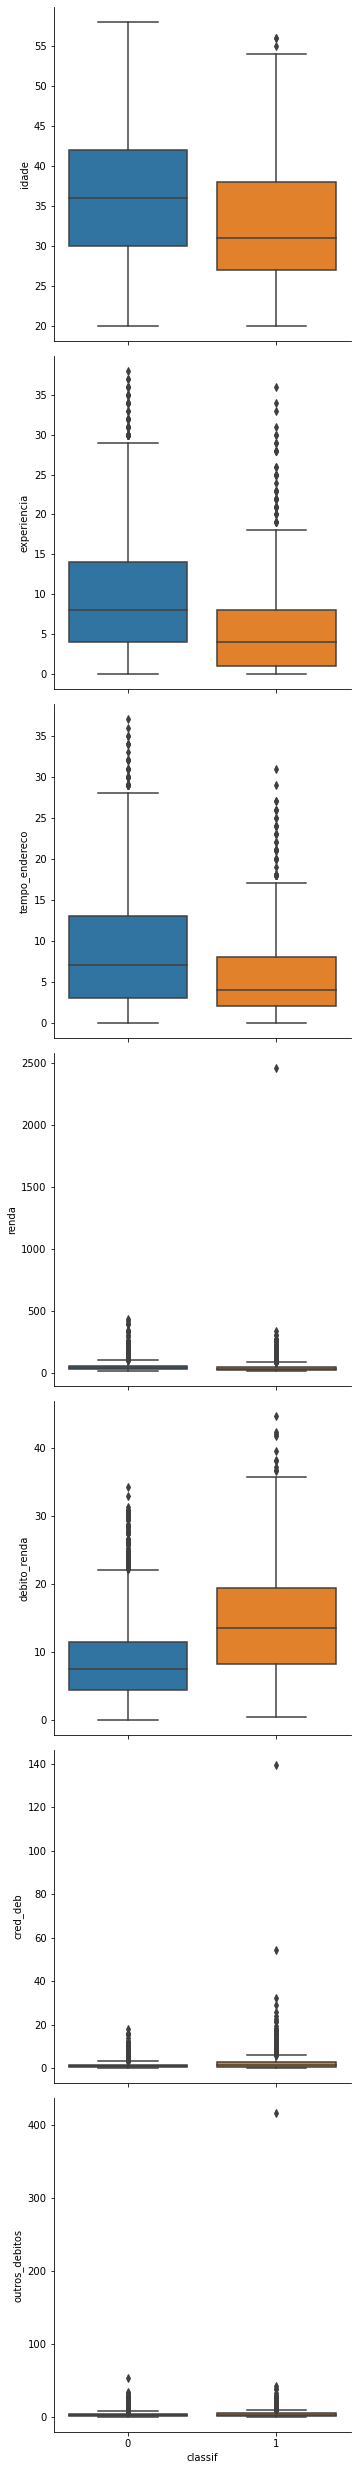

In [5]:
g = sns.PairGrid(data=df,
             x_vars='classif',
             y_vars=[i for i in df.columns if i != 'classif'],
             height=5)

g.map(sns.boxplot, )

**(c) Qual o % de empréstimos não pagos (ou “% de maus”, ou “% de default”)?**

In [6]:
pd.DataFrame(df.groupby(['classif']).size()/df.classif.count())

,0
classif,
0,0.7488
1,0.2512


**(d) Qual a correlação entre as variáveis presentes na base?**

<AxesSubplot:>

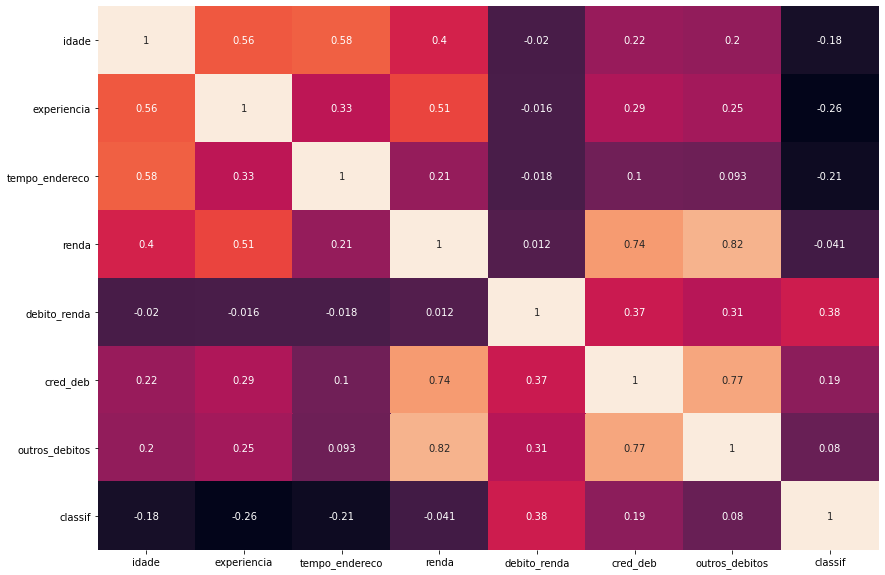

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cbar=False)

**(e) Quais são as variáveis que melhor explicam se o empréstimo foi pago ou não?**

As variáveis que mais explicam o modelo são renda e outros_debitos.

**(f) Ajuste um modelo logístico e avalie quais variáveis apareceram como significantes e quais não.**

In [15]:
#Modelo excluindo Salario_anual, pois o P>|z| é maior que 0,1
log_reg = sm.logit("classif ~ experiencia + tempo_endereco + debito_renda + cred_deb",
                   data = df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.404462
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                classif   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4995
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                  0.2824
Time:                        14:18:35   Log-Likelihood:                -2022.3
converged:                       True   LL-Null:                       -2818.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9904      0.092    -10.774      0.000      -1.171      -0.810
experiencia      

**(g) Calcule o score de propensão a default como uma coluna nova na base.**

In [18]:
df['prob'] = log_reg.predict(df[df.columns.drop('classif')])
df.head()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,classif,prob
0,41,17,12,35.9,11.90,0.504108,3.767992,0,0.020302
1,30,13,8,46.7,17.88,1.352694,6.997266,0,0.142269
2,40,15,14,61.8,10.64,3.438997,3.136523,0,0.073558
3,41,15,14,72.0,29.67,4.165668,17.196732,0,0.418854
4,57,7,37,25.6,15.86,1.498199,2.561961,0,0.030047


**(h) Qual a sugestão inicial de ponto de corte para predizer se o empréstimo será pago ou não?**

A sugestão é a média da variável *classif*, ou seja, 0.251200.

**(i) Considerando essa sugestão, desenhe a matriz de confusão e qual a taxa de classificação correta?**

In [19]:
df['pred'] = [1 if i > 0.2512 else 0 for i in df.prob]

<AxesSubplot:>

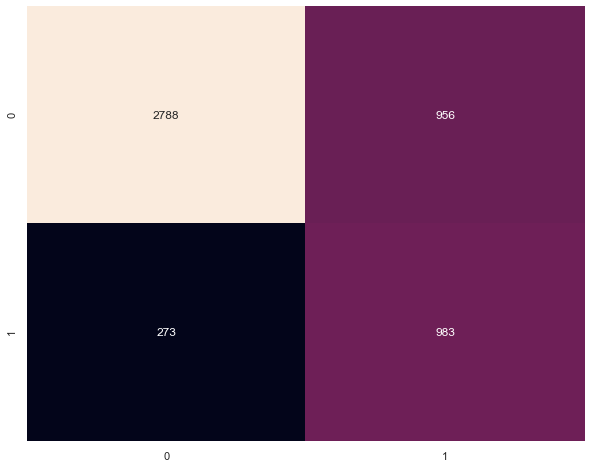

In [20]:
cm1 = confusion_matrix(df.classif, df.pred)
plt.figure(figsize=(10,8))
sns.set_theme()
sns.heatmap(cm1, annot = True, cbar=False, fmt='d')

In [21]:
print("Acurácia: %.2f" % accuracy_score(df.classif, df.pred))
print("Especificidade: %.2f" % (cm1[0,0]/(cm1[1,0]+cm1[0,0])))
print('Sensibilidade: %.2f' % (cm1[1,1]/(cm1[0,1]+cm1[1,1])))

Acurácia: 0.75
Especificidade: 0.91
Sensibilidade: 0.51


## Cálculo da estatística VIF

In [8]:
#gather features
features = "+".join(['experiencia', 'tempo_endereco', 'debito_renda', 'cred_deb'])

# get y and X dataframes based on this regression:
y, X = dmatrices('classif ~' + features, df, return_type='dataframe')

In [13]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [14]:
vif

,VIF Factor,features
0,5.782769,Intercept
1,1.226531,experiencia
2,1.121401,tempo_endereco
3,1.177353,debito_renda
4,1.281908,cred_deb
